In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs visíveis:", tf.config.list_physical_devices('GPU'))


TF: 2.19.0
GPUs visíveis: []


In [5]:
import os
import zipfile

if not os.path.exists('/content/trashnet'):
    print("Baixando o repositório do TrashNet...")
    !git clone https://github.com/garythung/trashnet.git
else:
    print("Repositório já baixado.")

zip_path = "/content/trashnet/data/dataset-resized.zip"
extract_path = "/content/dataset_final"

if os.path.exists(zip_path):
    print(f"Descompactando {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_path)
    print("Descompactação concluída!")
else:
    print("Erro: Arquivo zip não encontrado no repositório.")

Baixando o repositório do TrashNet...
Cloning into 'trashnet'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 45 (delta 6), reused 0 (delta 0), pack-reused 33 (from 1)
Receiving objects: 100% (45/45), 40.64 MiB | 28.35 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Descompactando /content/trashnet/data/dataset-resized.zip...
Descompactação concluída!


In [6]:
import pydot
print("Pydot version:", pydot.__version__)
import shutil
print("Graphviz no PATH:", shutil.which("dot"))



Pydot version: 4.0.1
Graphviz no PATH: /usr/bin/dot


In [7]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight

In [8]:
!pip install -q datasets
from datasets import load_dataset
import os
import shutil
from tqdm import tqdm

dataset = load_dataset("garythung/trashnet", split="train")
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 5054
})


In [9]:
warnings.filterwarnings("ignore")

In [11]:
from pathlib import Path
import os

# Tenta encontrar onde a pasta 'dataset-resized' foi parar
possible_paths = [
    Path("/content/dataset_final/dataset-resized"),  # Se usou meu script anterior
    Path("/content/trashnet/data/dataset-resized"),  # Se usou git clone puro
    Path("/content/dataset-resized")                 # Se extraiu na raiz
]

data_path = None
for p in possible_paths:
    if p.exists():
        data_path = p
        break

# Se achou, continua o código
if data_path:
    print(f"✅ Pasta de imagens encontrada em: {data_path}")
    print("Classes encontradas:", [d.name for d in data_path.iterdir() if d.is_dir()])
else:
    print("❌ Erro: A pasta do dataset não foi encontrada. Rode a célula de download novamente.")


✅ Pasta de imagens encontrada em: /content/dataset_final/dataset-resized
Classes encontradas: ['cardboard', 'plastic', 'glass', 'paper', 'trash', 'metal']


In [13]:
from pathlib import Path
import pandas as pd

data_path = Path("/content/dataset_final/dataset-resized")
print("Classes encontradas:", [d.name for d in data_path.iterdir() if d.is_dir()])

data = []
for folder in data_path.iterdir():
    if folder.is_dir():
        file_count = len(list(folder.glob("*")))
        data.append({"Folder Name": folder.name, "File Count": file_count})

count = pd.DataFrame(data).set_index("Folder Name")
count


Classes encontradas: ['cardboard', 'plastic', 'glass', 'paper', 'trash', 'metal']


,File Count
Folder Name,
cardboard,403
plastic,482
glass,501
paper,594
trash,137
metal,410


In [14]:
print(f'Total {count.sum()}')

Total File Count    2527
dtype: int64


In [15]:
# Show five image of each class
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

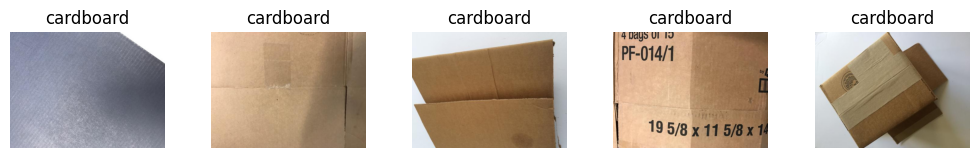

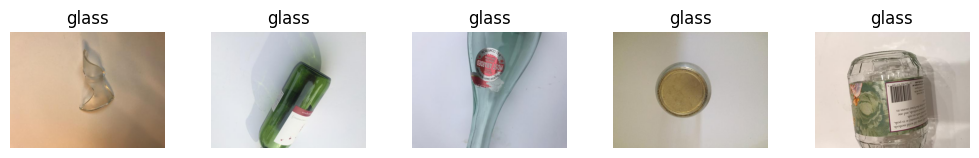

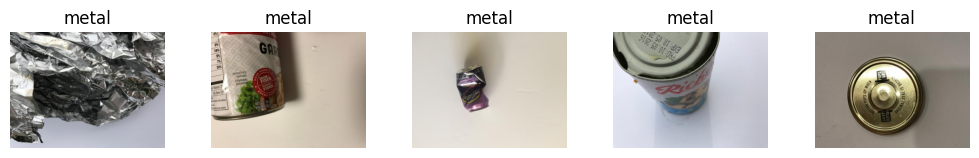

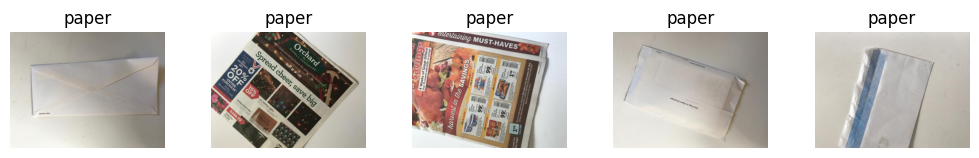

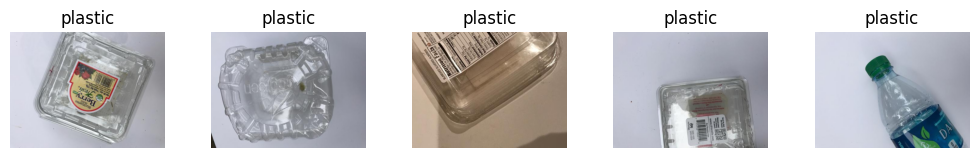

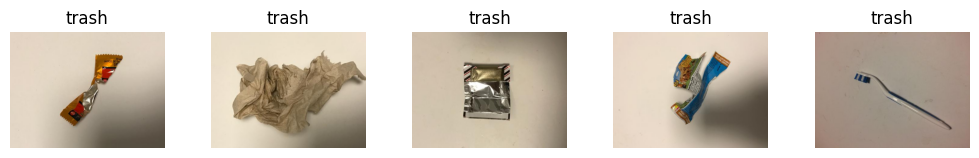

In [16]:
plot_imgs(data_path / 'cardboard')
plot_imgs(data_path / 'glass')
plot_imgs(data_path / 'metal')
plot_imgs(data_path / 'paper')
plot_imgs(data_path / 'plastic')
plot_imgs(data_path / 'trash')


In [17]:
# Define variable for requirements
batch_size = 30
target_size = (128, 128)

validation_split = 0.15

In [18]:
train_img_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=50,
    shear_range=0.3,
    fill_mode='nearest'
)

test_data_img_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=validation_split
)


In [19]:
train_data = train_img_generator.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True,
    seed=42
)

test_data = test_data_img_generator.flow_from_directory(
    data_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation',
    shuffle=False,
    seed=42
)


Found 2150 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [20]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2150 images belonging to 6 classes.


In [21]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 377 images belonging to 6 classes.


In [22]:
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [23]:
import sys
print("Python do notebook:", sys.executable)

!{sys.executable} -m pip install pydot graphviz

import pydot
print("Pydot carregado de:", pydot.__file__)


Python do notebook: /usr/bin/python3
Pydot carregado de: /usr/local/lib/python3.12/dist-packages/pydot/__init__.py


In [24]:
import shutil
print("dot no sistema:", shutil.which("dot"))


dot no sistema: /usr/bin/dot


In [25]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 130, 130, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 29, 29, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,286 (12.64 MB)

 Trainable params: 3,313,286 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [27]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [28]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

In [30]:
print("Classes e índices:", train_data.class_indices)
print("Número de classes:", train_data.num_classes)


Classes e índices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Número de classes: 6


In [32]:
epochs = 20

history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data,
    callbacks=[ES, RLROP, MCH]
)


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.3526 - loss: 1.5038

72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - categorical_accuracy: 0.3531 - loss: 1.5034 - val_categorical_accuracy: 0.3289 - val_loss: 1.5608 - learning_rate: 0.0010
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4112 - loss: 1.4587

72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - categorical_accuracy: 0.4113 - loss: 1.4584 - val_categorical_accuracy: 0.3448 - val_loss: 1.5312 - learning_rate: 0.0010
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - categorical_accuracy: 0.4725 - loss: 1.3530 - val_categorical_accuracy: 0.3634 - val_loss: 1.5521 - learning_rate: 0.0010
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - categorical_accuracy: 0.5008 - loss: 1.2699 - val_categorical_accuracy: 0.4138 - val_loss: 1.5469 - learning_rate: 0.0010
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4920 - loss: 1.2995

72/72 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - categorical_accuracy: 0.4920 - loss: 1.2997 - val_categorical_accuracy: 0.3846 - val_loss: 1.5243 - learning_rate: 0.0010
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4957 - loss: 1.2991

72/72 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - categorical_accuracy: 0.4956 - loss: 1.2993 - val_categorical_accuracy: 0.4111 - val_loss: 1.4897 - learning_rate: 0.0010
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5012 - loss: 1.2638

72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - categorical_accuracy: 0.5013 - loss: 1.2641 - val_categorical_accuracy: 0.4509 - val_loss: 1.4890 - learning_rate: 0.0010
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - categorical_accuracy: 0.5205 - loss: 1.2644 - val_categorical_accuracy: 0.4536 - val_loss: 1.5163 - learning_rate: 0.0010
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5402 - loss: 1.2151

72/72 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - categorical_accuracy: 0.5400 - loss: 1.2154 - val_categorical_accuracy: 0.4668 - val_loss: 1.4768 - learning_rate: 0.0010
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5075 - loss: 1.2347

72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - categorical_accuracy: 0.5077 - loss: 1.2346 - val_categorical_accuracy: 0.4748 - val_loss: 1.4048 - learning_rate: 0.0010
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - categorical_accuracy: 0.5015 - loss: 1.2693 - val_categorical_accuracy: 0.4615 - val_loss: 1.4467 - learning_rate: 0.0010
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - categorical_accuracy: 0.5096 - loss: 1.2473 - val_categorical_accuracy: 0.4536 - val_loss: 1.4391 - learning_rate: 0.0010
Epoch 13/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - categorical_accuracy: 0.5460 - loss: 1.1657 - val_categorical_accuracy: 0.4748 - val_loss: 1.4292 - learning_rate: 0.0010
Epoch 14/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - categorical_accuracy: 0.5410 - loss: 1.1989 - val_categorical_accuracy: 0.4907 - val_loss: 1.4153 - learning_rate: 0.0010
Epoch 15/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - categorical_accuracy: 0.5527 - loss: 1.1802 - val_categorical_accuracy: 0.4854

In [33]:

loss, acc = model.evaluate(test_data)
print(f"Loss de validação: {loss:.4f}")
print(f"Acurácia de validação: {acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 550ms/step - categorical_accuracy: 0.5011 - loss: 1.4107
Loss de validação: 1.4144
Acurácia de validação: 0.4934


In [34]:
best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.4933687150478363


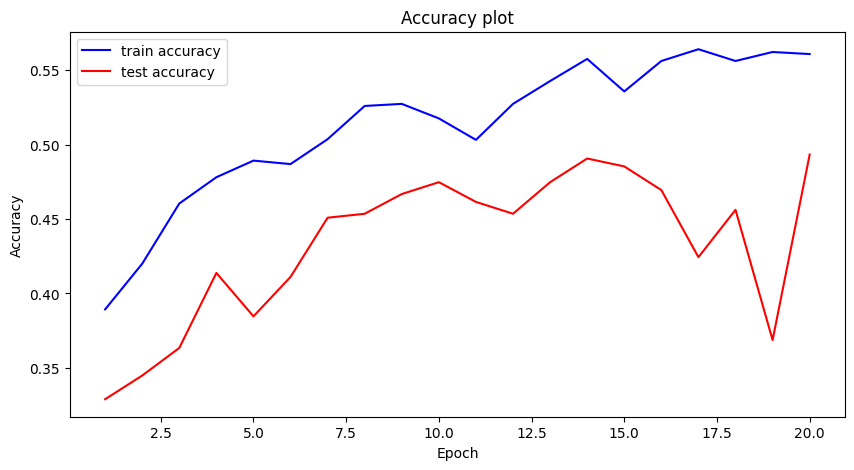

In [35]:
# Accuracy on train data :
accuracy = history.history['categorical_accuracy']

# Accuracy on test data :
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)  # Epochs

# Accuracy line plot :
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [36]:
classes = train_data.class_indices
classes

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [38]:
import os

folder = "/content/dataset_final/dataset-resized/paper"
print(os.listdir(folder)[:20])


['paper119.jpg', 'paper578.jpg', 'paper353.jpg', 'paper557.jpg', 'paper160.jpg', 'paper140.jpg', 'paper307.jpg', 'paper263.jpg', 'paper437.jpg', 'paper575.jpg', 'paper82.jpg', 'paper107.jpg', 'paper111.jpg', 'paper126.jpg', 'paper547.jpg', 'paper91.jpg', 'paper421.jpg', 'paper69.jpg', 'paper436.jpg', 'paper466.jpg']


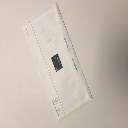

In [40]:
from tensorflow.keras.preprocessing import image as utils

img_path = "/content/dataset_final/dataset-resized/paper/paper11.jpg"

img = utils.load_img(
    img_path,
    color_mode='rgb',
    target_size=target_size,
    interpolation='nearest'
)

img


In [41]:

import numpy as np
import tensorflow as tf

img_array = utils.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)

idx_to_class = {v: k for k, v in train_data.class_indices.items()}

pred_class_idx = np.argmax(pred, axis=1)[0]
print("Classe prevista:", idx_to_class[pred_class_idx])
print("Distribuição de probabilidade:", pred[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Classe prevista: glass
Distribuição de probabilidade: [0.03110718 0.31951812 0.1112255  0.29328626 0.139606   0.1052568 ]


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step


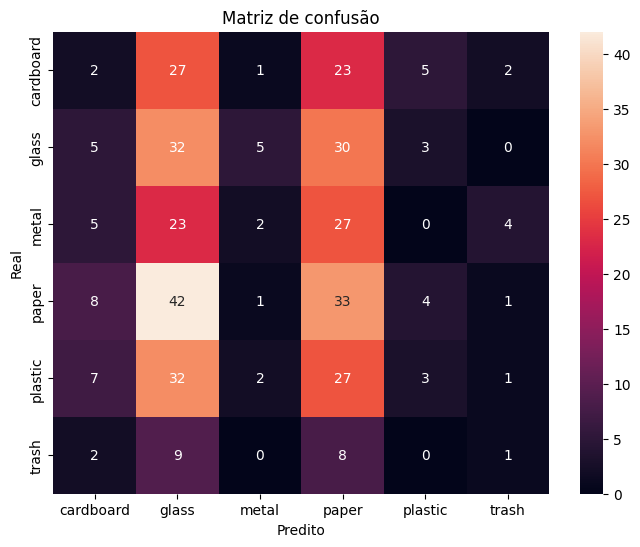

              precision    recall  f1-score   support

   cardboard       0.07      0.03      0.04        60
       glass       0.19      0.43      0.27        75
       metal       0.18      0.03      0.06        61
       paper       0.22      0.37      0.28        89
     plastic       0.20      0.04      0.07        72
       trash       0.11      0.05      0.07        20

    accuracy                           0.19       377
   macro avg       0.16      0.16      0.13       377
weighted avg       0.18      0.19      0.15       377



In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

test_data.shuffle = False

y_true = test_data.classes
y_pred_proba = model.predict(test_data)
y_pred = np.argmax(y_pred_proba, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = list(test_data.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de confusão")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))
